# Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    average_precision_score, 
    precision_recall_curve
)

# Load Dataset

In [ ]:
df = pd.read_csv("titanic_dataset.csv")

# Initial information about dataset
df.info()

# Drop Cabin column (too many missing values)
df = df.drop(columns=["Cabin"])
df.info()

# Exploratory Data Analysis (EDA)

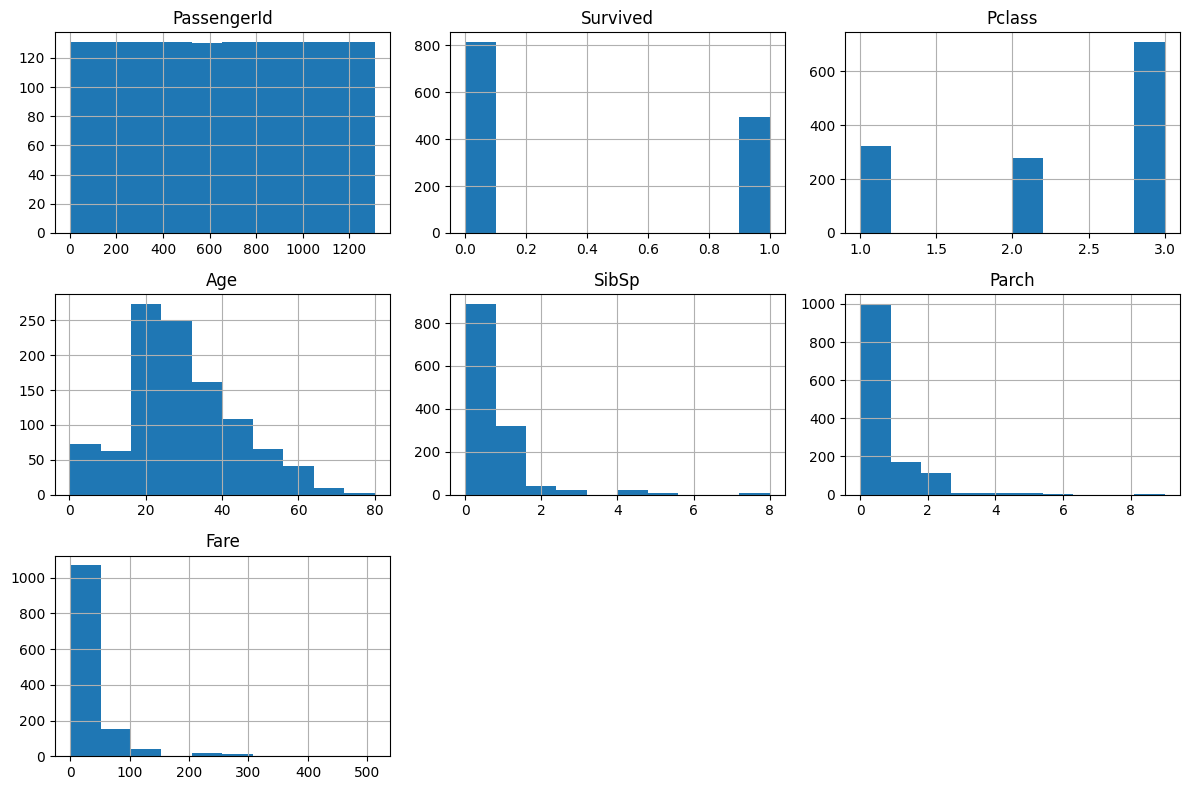

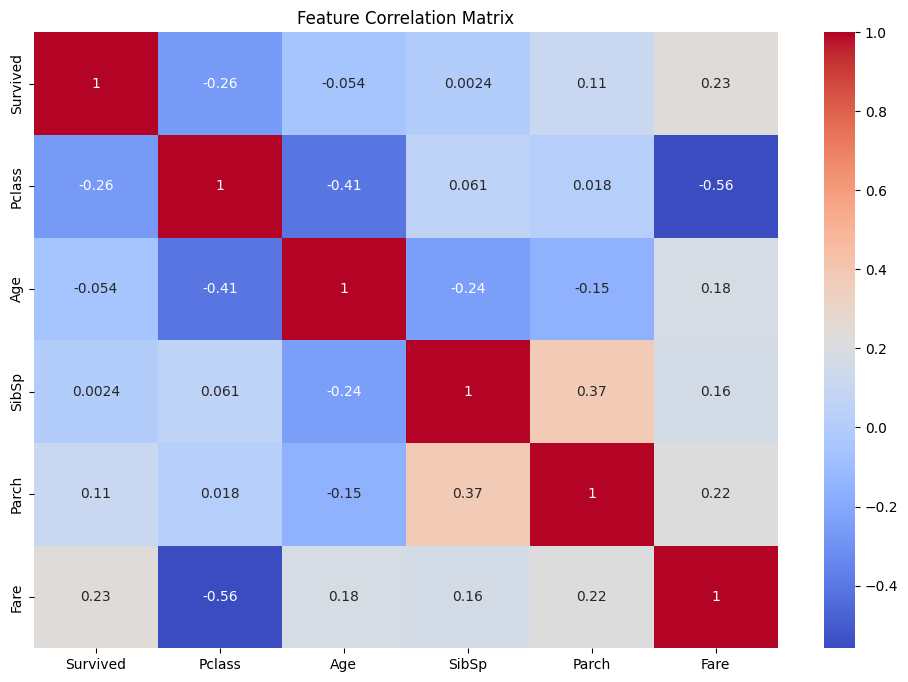

In [3]:
# Histogram of all numerical features
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
df_num = df.select_dtypes(include="number").drop(columns="PassengerId")
corr_matrix = df_num.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

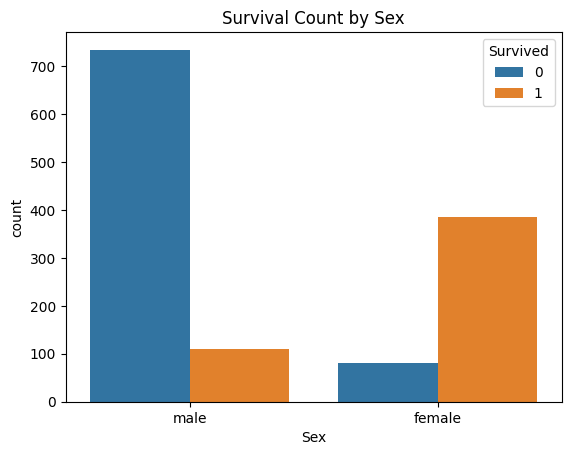

In [14]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival Count by Sex')
plt.show()


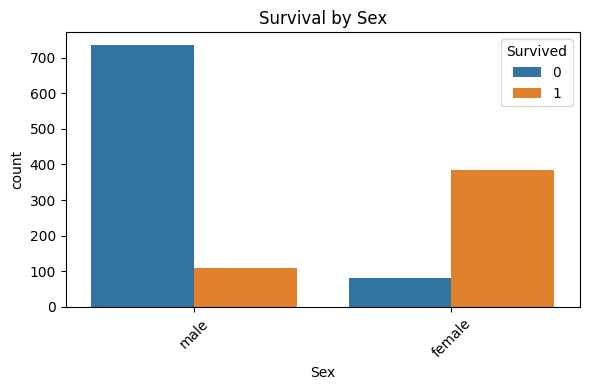

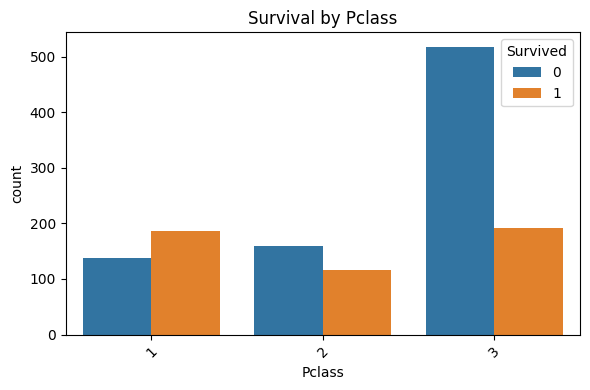

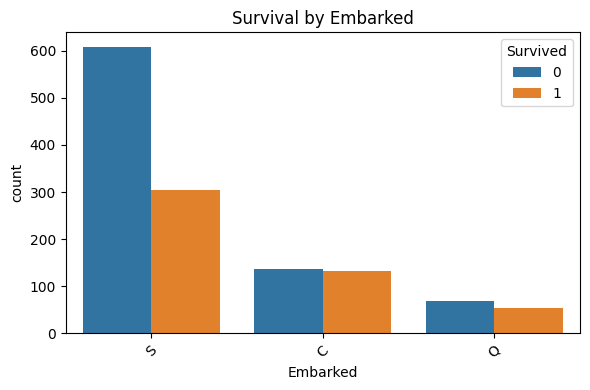

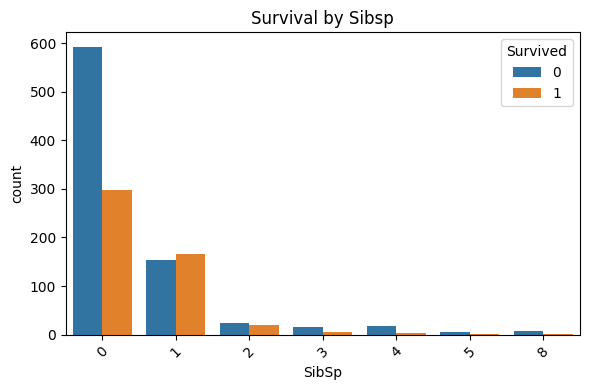

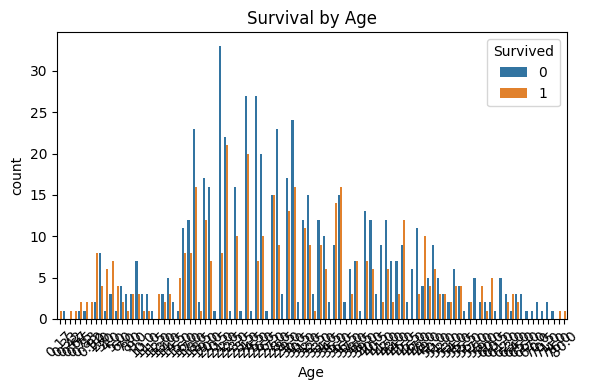

In [18]:
categorical_cols = ['Sex', 'Pclass', 'Embarked','SibSp', 'Age']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='Survived')
    plt.title(f'Survival by {col.capitalize()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Train/Test Split


In [4]:
X = df.drop(columns=["PassengerId", "Survived"])
y = df["Survived"]

# Class distribution check (imbalance analysis)
print(df['Survived'].value_counts())

# Stratified split to preserve target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

# Separate categorical and numerical columns
num_cols = df_num.columns.to_list()
cat_cols = [c for c in df.columns if c not in num_cols]
print("Categorical:", cat_cols, "\nNumerical:", num_cols)


Survived
0    815
1    494
Name: count, dtype: int64
Categorical: ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 
Numerical: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Preprocessing Pipeline


In [5]:
imputer = SimpleImputer(strategy='most_frequent')

# Categorical preprocessing (impute + one-hot-encode)
pipe_pre = Pipeline([
    ("impute", imputer),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer (only categorical preprocessing here)
ct = ColumnTransformer([
    ("cat", pipe_pre, cat_cols)
])

# Model Definition

In [6]:
model_rf = RandomForestClassifier()

# Full pipeline: preprocessing + model
pipe_main = Pipeline([
    ("pre", pipe_pre),
    ("clf", model_rf)
])

# Model Training


In [7]:
pipe_main.fit(X_train, y_train)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute', ...), ('encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


# Baseline Evaluation (Default Threshold = 0.5)

In [8]:
# Predictions
y_pred_base = pipe_main.predict(X_test)

# Accuracy & F1
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1:", f1_score(y_test, y_pred_base))

Baseline Accuracy: 0.8518518518518519
Baseline F1: 0.7880794701986755


# Precision-Recall Analysis (Finding Best Threshold)


In [9]:
# Predicted probabilities
proba_test = pipe_main.predict_proba(X_test)[:, 1]

# Average Precision (area under PR curve)
ap = average_precision_score(y_test, proba_test)
print(f"Average Precision (PR-AUC): {ap:.3f} | Baseline ~ {y.mean():.3f}")

# Precision-Recall curve to find best F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1s = (2*prec*rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best F1={f1s[best_idx]:.3f} at threshold={best_thr:.3f}")

Average Precision (PR-AUC): 0.879 | Baseline ~ 0.377
Best F1=0.796 at threshold=0.430


# Final Evaluation (Optimized Threshold)


In [10]:
# Apply custom threshold
y_pred = (proba_test >= best_thr).astype(int)

print("Final F1:", f1_score(y_test, y_pred))
print("Final Accuracy:", accuracy_score(y_test, y_pred))

Final F1: 0.7961165048543689
Final Accuracy: 0.8541666666666666
